In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import pandas as pd
import numpy as np

%matplotlib inline

#### Load data

In [2]:
files = glob.glob("*.csv")
data = None
for f in files:
    if data is None:
        data = pd.read_csv(f, skipfooter = 2, engine='python')
    else:
        data = pd.concat([data, pd.read_csv(f, skipfooter = 2, engine='python')])

data.columns = ['date', 'price']
data = data.drop_duplicates('date')
data = data.reset_index(drop=True)
data.date = pd.to_datetime(data.date)
data = data.sort_values(by=['date'])

price_open = data.price.as_matrix()[:-1]
price_close = data.price.as_matrix()[1:]

#### Utility functions

In [3]:
def evaluate_strategy(price, actions, action_price):
    '''Evaluate strategy and return growth
    
    price: historical price data
    actions: decision at each point: -1 = sell, 0 = no action, 1 = buy
    action_price: usd price for each action
    '''
    result = np.ones(len(actions)) # Growth history
    btc = 1                        # Current number of btc
    usd = 0                        # Current number of usd
    last_action = None             # Last non-zero action
    
    # Loop for every time point
    for i, a in enumerate(actions):
        if a != 0:
            if last_action is None:
                # First action
                # If it is a sell, skip action
                # Otherwise perform first purchase
                
                if a == -1:
                    continue
                
                btc = 1
                usd = 0
                last_action = a
                continue
            
            # Do trade
            if a == 1:
                # Buy
                btc = (usd-action_price)/price[i]
                usd = 0
            else:
                # Sell
                usd = btc*price[i]-action_price
                btc = 0
            
            last_action = a

        result[i] = (usd + btc * price[i]) / price[0]
    
    return result

def moving_sum(X, n):
    return np.array([sum(X[i:i+n]) for i in range(X.shape[0]-n+1)])

def moving_ratio(price_open, price_close, n):
    return np.array([price_open[i]/price_close[i-n] for i in range(n, len(price_open))])
            

#### Test parameters

In [4]:
# Period to evaluate
start, end = 0, price_close.shape[0]-1
# Number of minutes in the past for window function (ratio)
dt = 17
# Threshold for entering when rising
threshold_up = 0.01
# Threshold for leaving when falling
threshold_down = 0.005
# Minimum number of rising minutes to enter
peak_width = 0
# Minimum number of falling minutes to leave
valley_width = 0
# Price per action
action_price = 1

# moving ratio
dx = moving_ratio(price_open, price_close, dt)[start:end]

# flag up or down trend if:
# 1. ratio with earlier price crosses threshold
# 2. prices are rising/falling for at least [peak_width]/[valley_width] minutes
up = (dx >= 1+threshold_up) & (moving_sum(dx > 1, max(1, peak_width)) >= peak_width)[max(1, peak_width)-1:]
down = (dx <= 1-threshold_down) & (moving_sum(dx < 1, max(1, valley_width)) >= valley_width)[ max(1, valley_width)-1:]

# Encode actions
actions = (up+0-down)

# Set repeated actions (consecutive sell/buy actions) to 0
_a = actions[0]
for i, a in enumerate(actions):
    if a != 0:
        if a == _a:
            actions[i] = 0
        _a = a

# Save decision points
idx_down = np.where(actions==-1)[0]
idx_up = np.where(actions==1)[0]

Some plots for visual inspcetion

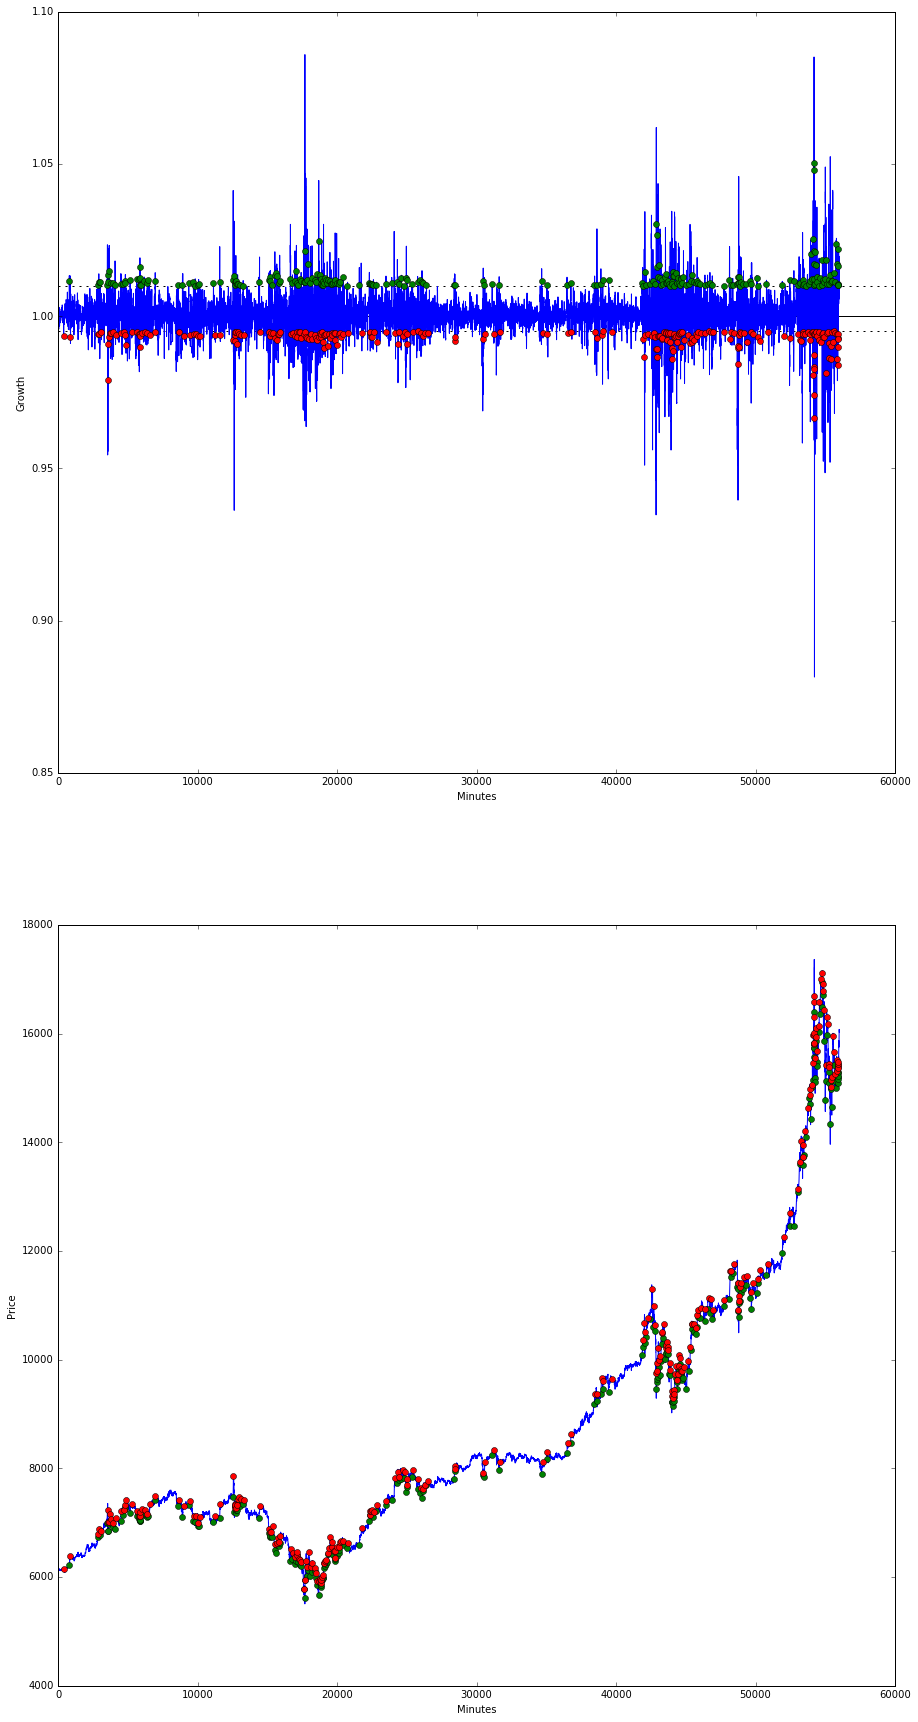

In [5]:
plt.figure(0, figsize=(15,30))
plt.subplot(2,1,1)
plt.axhline(1, color='black')

# plot decision boundaries
plt.axhline(1-threshold_down, color='black', dashes=[2,5])
plt.axhline(1+threshold_up, color='black', dashes=[2,5])

# plot moving ratio
plt.plot(dx)
plt.xlabel("Minutes")
plt.ylabel("Growth")

# plot actions
plt.plot(idx_up, dx[idx_up], 'og')
plt.plot(idx_down, dx[idx_down], 'or')

# plot actual price and decisions
plt.subplot(2,1,2)
plt.plot(price_close[start:end])
plt.plot(idx_up, price_close[start:end][idx_up], 'og')
plt.plot(idx_down, price_close[start:end][idx_down], 'or')
plt.xlabel("Minutes")
plt.ylabel("Price")

pass

#### Evalueate strategy

Strategy result: 5555%
Market result: 261%
Actions: 508


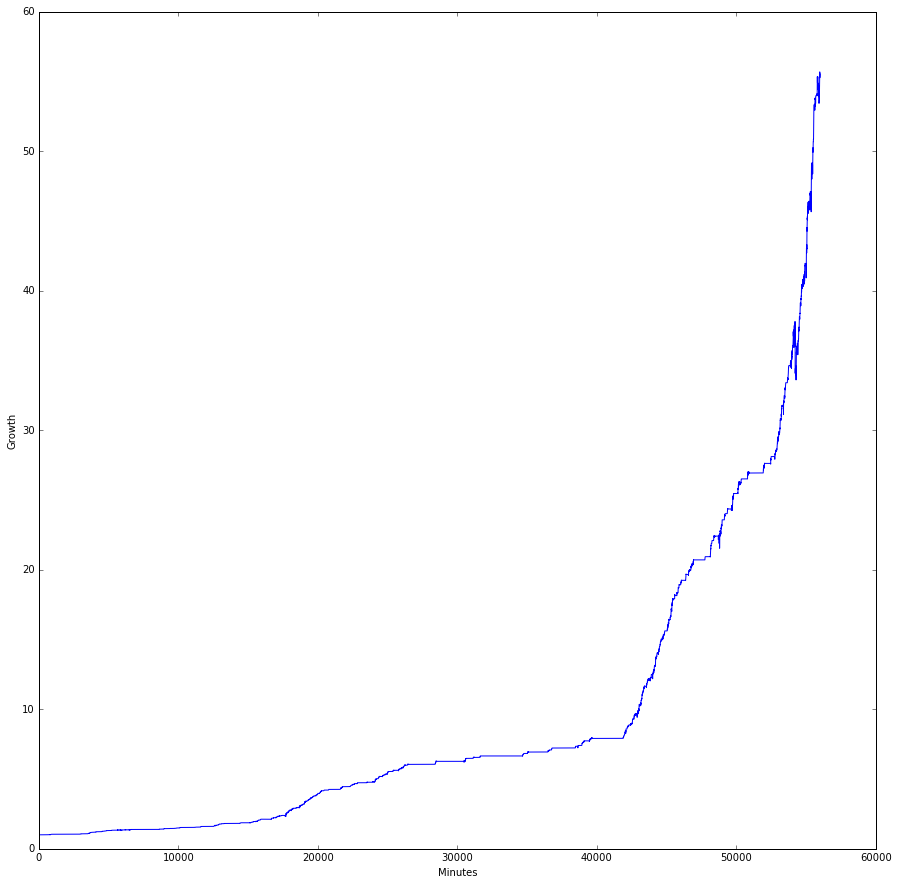

In [6]:
result = evaluate_strategy(price_open[start:end], actions, action_price)
plt.figure(1, figsize=(15,15))
plt.plot(result)
plt.xlabel("Minutes")
plt.ylabel("Growth")
print("Strategy result: %.0f%%\nMarket result: %.0f%%" % (result[-1]*100, 
                                                          price_close[end]/price_close[start]*100))
print("Actions: %d" % sum(actions != 0))

Test random strategy

Strategy result: 87%
Market result: 262%
Actions: 1152


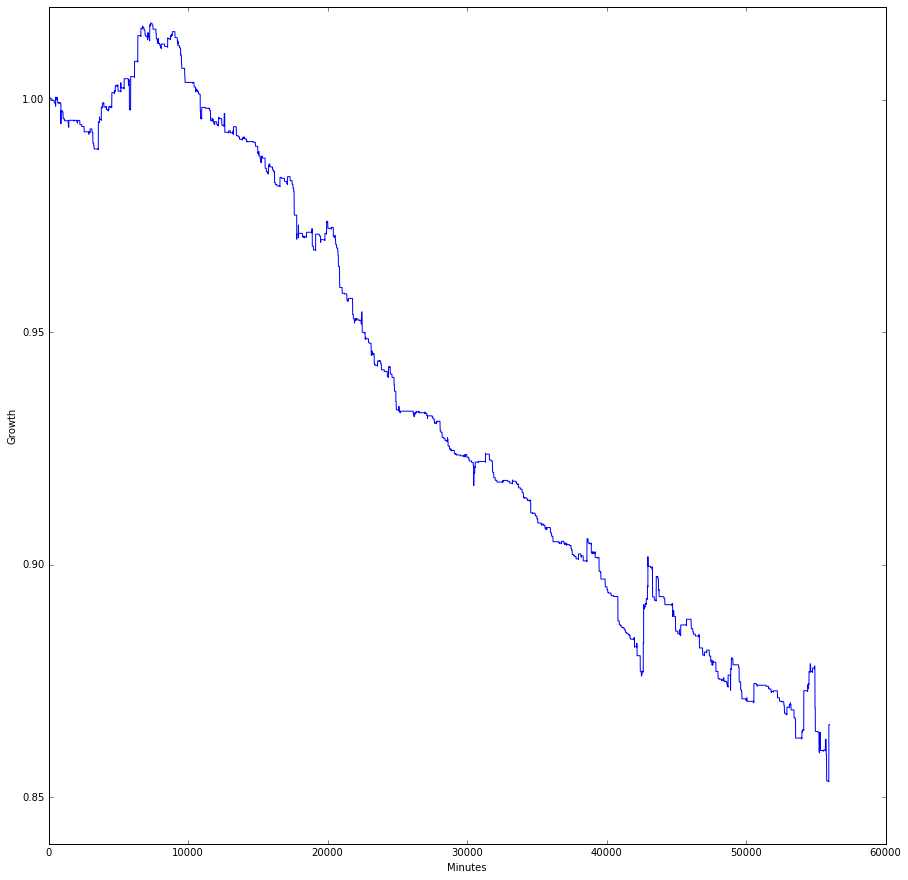

In [7]:
# Generate random actions
p_action = 0.1
actions = (np.random.uniform(0, 1, (2,actions.shape[0])) < p_action).sum(0)-1

# Set repeated actions (consecutive sell/buy actions) to 0
_a = actions[0]
for i, a in enumerate(actions):
    if a != 0:
        if a == _a:
            actions[i] = 0
        _a = a

# Save decision points
idx_down = np.where(actions==-1)[0]
idx_up = np.where(actions==1)[0]

result = evaluate_strategy(data.price.values[start:end], actions, action_price)
plt.figure(1, figsize=(15,15))
plt.plot(result)
plt.xlabel("Minutes")
plt.ylabel("Growth")
print("Strategy result: %.0f%%\nMarket result: %.0f%%" % (result[-1]*100, 
                                                          data.price.values[end]/data.price.values[start]*100))
print("Actions: %d" % sum(actions != 0))